In [1]:
print("beliver")

beliver


In [2]:
import json
import random
import math
from datetime import datetime, timedelta
from typing import List, Dict, Any

# --------------------------
# Utility Functions
# --------------------------

def haversine(coord1: tuple, coord2: tuple) -> float:
    """
    Calculate the great-circle distance between two points 
    on the Earth (specified in decimal degrees)
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # Convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    
    # Radius of earth in kilometers (6371)
    km = 6371 * c
    return km

def generate_mock_data(num_riders: int = 100, num_stations: int = 3) -> Dict:
    """
    Generate mock input data around Pune, India coordinates
    """
    # Pune center coordinates
    pune_center = (18.5204, 73.8567)
    
    # Generate riders
    riders = []
    for i in range(num_riders):
        rider_id = f"R{str(i).zfill(3)}"
        lat = pune_center[0] + random.uniform(-0.1, 0.1)
        lng = pune_center[1] + random.uniform(-0.1, 0.1)
        soc_pct = random.randint(10, 100)
        status = random.choice(["idle", "on_gig"])
        
        if status == "on_gig":
            km_to_finish = random.uniform(1, 20)
            finish_time = datetime.utcnow() + timedelta(minutes=random.randint(5, 120))
            est_finish_ts = finish_time.isoformat() + "Z"
        else:
            km_to_finish = 0
            est_finish_ts = ""
        
        riders.append({
            "rider_id": rider_id,
            "lat": lat,
            "lng": lng,
            "soc_pct": soc_pct,
            "status": status,
            "km_to_finish": km_to_finish if status == "on_gig" else None,
            "est_finish_ts": est_finish_ts if status == "on_gig" else None
        })
    
    # Generate stations
    stations = []
    for i in range(num_stations):
        station_id = f"S_{chr(65 + i)}"
        lat = pune_center[0] + random.uniform(-0.05, 0.05)
        lng = pune_center[1] + random.uniform(-0.05, 0.05)
        queue_len = random.randint(0, 4)
        
        stations.append({
            "station_id": station_id,
            "lat": lat,
            "lng": lng,
            "queue_len": queue_len
        })
    
    return {
        "riders": riders,
        "stations": stations,
        "timestamp": datetime.utcnow().isoformat() + "Z"
    }

# --------------------------
# Core Optimization Logic
# --------------------------

class BatterySwapOptimizer:
    def __init__(self, input_data: Dict):
        self.riders = input_data["riders"]
        self.stations = input_data["stations"]
        self.time_window = 60  # minutes
        self.current_time = 0  # simulation starts at t=0
        self.swap_duration = 4  # minutes per swap
        self.avg_speed = 0.5   # km per minute (30 km/h)
        self.soc_consumption = 4  # % per km
        
        # Track station queues over time
        self.station_queues = {s["station_id"]: [] for s in self.stations}
        
        # Initialize with current queue lengths
        for station in self.stations:
            for _ in range(station["queue_len"]):
                self._add_to_station_queue(station["station_id"], 0)
    
    def _add_to_station_queue(self, station_id: str, arrival_time: float):
        """Add a rider to station queue at given arrival time"""
        if not self.station_queues[station_id]:
            swap_start = arrival_time
        else:
            last_swap_end = self.station_queues[station_id][-1]["swap_end_ts"]
            swap_start = max(arrival_time, last_swap_end)
        
        swap_end = swap_start + self.swap_duration
        self.station_queues[station_id].append({
            "arrival_ts": arrival_time,
            "swap_start_ts": swap_start,
            "swap_end_ts": swap_end
        })
    
    def _get_queue_length_at_time(self, station_id: str, time: float) -> int:
        """Get number of riders in queue at a specific time"""
        return sum(1 for rider in self.station_queues[station_id] 
                 if rider["arrival_ts"] <= time < rider["swap_end_ts"])
    
    def _find_best_station(self, rider: Dict) -> Dict:
        """Find the best station for a rider considering distance and queue"""
        rider_loc = (rider["lat"], rider["lng"])
        remaining_km = (rider["soc_pct"] - 10) / self.soc_consumption  # 10% buffer
        
        # Get all stations within remaining range
        viable_stations = []
        for station in self.stations:
            distance = haversine(rider_loc, (station["lat"], station["lng"]))
            if distance <= remaining_km:
                travel_time = distance / self.avg_speed
                arrival_time = self.current_time + travel_time
                
                # Check if queue would be <=5 at arrival time
                projected_queue = self._get_queue_length_at_time(
                    station["station_id"], arrival_time)
                
                if projected_queue < 5:
                    viable_stations.append({
                        "station": station,
                        "distance": distance,
                        "travel_time": travel_time,
                        "arrival_time": arrival_time,
                        "queue_at_arrival": projected_queue
                    })
        
        if not viable_stations:
            return None
        
        # Sort by total time (travel + wait)
        viable_stations.sort(key=lambda x: (
            x["travel_time"] + 
            (x["queue_at_arrival"] * self.swap_duration)
        ))
        
        return viable_stations[0]
    
    def optimize(self) -> List[Dict]:
        """Main optimization function"""
        scheduled_swaps = []
        
        # Sort riders by urgency (SOC/distance ratio)
        self.riders.sort(key=lambda r: (
            r["soc_pct"] / 
            (haversine((r["lat"], r["lng"]), 
                      (self.stations[0]["lat"], self.stations[0]["lng"])) + 0.1)
        ))
        
        for rider in self.riders:
            # Skip if rider is on gig and won't finish within time window
            if rider["status"] == "on_gig" and rider["km_to_finish"] > 0:
                finish_time = (rider["km_to_finish"] / self.avg_speed)
                if finish_time > self.time_window:
                    continue
            
            # Find best station
            best_station = self._find_best_station(rider)
            if not best_station:
                continue
            
            # Schedule the swap
            self._add_to_station_queue(
                best_station["station"]["station_id"],
                best_station["arrival_time"])
            
            scheduled_swaps.append({
                "rider_id": rider["rider_id"],
                "station_id": best_station["station"]["station_id"],
                "depart_ts": self.current_time,
                "arrive_ts": best_station["arrival_time"],
                "swap_start_ts": self.station_queues[best_station["station"]["station_id"]][-1]["swap_start_ts"],
                "swap_end_ts": self.station_queues[best_station["station"]["station_id"]][-1]["swap_end_ts"],
                "eta_back_lat": rider["lat"],
                "eta_back_lng": rider["lng"]
            })
        
        return scheduled_swaps

# --------------------------
# Main Execution
# --------------------------

def main():
    # Step 1: Generate mock input data
    input_data = generate_mock_data(num_riders=100, num_stations=3)
    
    # Save input data for reference
    with open("input_data.json", "w") as f:
        json.dump(input_data, f, indent=2)
    
    # Step 2: Run optimization
    optimizer = BatterySwapOptimizer(input_data)
    output_plan = optimizer.optimize()
    
    # Step 3: Save output plan
    with open("swap_plan.json", "w") as f:
        json.dump(output_plan, f, indent=2)
    
    print(f"Optimization complete. Scheduled {len(output_plan)} battery swaps.")
    print("Input data saved to 'input_data.json'")
    print("Swap plan saved to 'swap_plan.json'")

if __name__ == "__main__":
    main()

Optimization complete. Scheduled 48 battery swaps.
Input data saved to 'input_data.json'
Swap plan saved to 'swap_plan.json'


C:\Users\Manish Alhat\AppData\Local\Temp\ipykernel_10856\3293231590.py:50: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  finish_time = datetime.utcnow() + timedelta(minutes=random.randint(5, 120))
C:\Users\Manish Alhat\AppData\Local\Temp\ipykernel_10856\3293231590.py:84: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z"


In [4]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
  Using cached folium-0.19.6-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached xyzservices-2025.4.0-py3-none-any.whl.metadata (4.3 kB)
Using cached folium-0.19.6-py2.py3-none-any.whl (112 kB)
Using cached branca-0.8.1-py3-none-any.whl (26 kB)
Using cached xyzservices-2025.4.0-py3-none-any.whl (90 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Interactive Map Visualization (using Folium)


In [5]:
import folium
from folium.plugins import MarkerCluster
import json

def visualize_on_map():
    # Load data
    with open('input_data.json') as f:
        input_data = json.load(f)
    with open('swap_plan.json') as f:
        swap_plan = json.load(f)
    
    # Create base map centered on Pune
    pune_center = [18.5204, 73.8567]
    m = folium.Map(location=pune_center, zoom_start=12)
    
    # Add stations with queue info
    station_group = folium.FeatureGroup(name="Swap Stations")
    for station in input_data['stations']:
        queue_len = sum(1 for swap in swap_plan 
                      if swap['station_id'] == station['station_id'])
        
        popup = f"""
        <b>{station['station_id']}</b><br>
        Queue: {queue_len}<br>
        Location: {station['lat']:.4f}, {station['lng']:.4f}
        """
        
        folium.Marker(
            [station['lat'], station['lng']],
            popup=popup,
            icon=folium.Icon(color='blue', icon='bolt', prefix='fa')
        ).add_to(station_group)
    station_group.add_to(m)
    
    # Add riders with SOC status
    rider_group = MarkerCluster(name="Riders")
    for rider in input_data['riders']:
        # Find if rider has a scheduled swap
        swap = next((s for s in swap_plan if s['rider_id'] == rider['rider_id']), None)
        
        # Determine marker color based on SOC
        if rider['soc_pct'] < 20:
            color = 'red'
        elif rider['soc_pct'] < 40:
            color = 'orange'
        else:
            color = 'green'
        
        popup = f"""
        <b>{rider['rider_id']}</b><br>
        SOC: {rider['soc_pct']}%<br>
        Status: {rider['status']}
        """
        
        if swap:
            popup += f"<br><b>Scheduled for swap at {swap['station_id']}</b>"
            folium.PolyLine(
                locations=[[rider['lat'], rider['lng']], 
                         [next(s for s in input_data['stations'] 
                              if s['station_id'] == swap['station_id'])['lat'],
                          next(s for s in input_data['stations'] 
                              if s['station_id'] == swap['station_id'])['lng']]],
                color='gray',
                weight=2,
                opacity=0.5
            ).add_to(m)
        
        folium.Marker(
            [rider['lat'], rider['lng']],
            popup=popup,
            icon=folium.Icon(color=color, icon='motorcycle', prefix='fa')
        ).add_to(rider_group)
    rider_group.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save and display
    m.save('battery_swap_map.html')
    return m

# Generate the map
map_viz = visualize_on_map()
map_viz

## 2. Gantt Chart for Swap Scheduling (using Plotly)

In [6]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   --------- ------------------------------ 3.9/16.1 MB 19.5 MB/s eta 0:00:01
   --------------- ------------------------ 6.3/16.1 MB 15.8 MB/s eta 0:00:01
   --------------------- ------------------ 8.7/16.1 MB 14.6 MB/s eta 0:00:01
   -------------------------- ------------- 10.5/16.1 MB 13.0 MB/s eta 0:00:01
   ------------------------------- -------- 12.6/16.1 MB 12.4 MB/s eta 0:00:01
   ------------------------------------- -- 15.2/16.1 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 16.1/16.1 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
pip install  pandas 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
!pip install --upgrade nbformat>=4.2.0


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import plotly.express as px
import pandas as pd
import json
from datetime import datetime, timedelta

def create_correct_gantt_chart():
    # Load swap plan
    with open('swap_plan.json') as f:
        swap_plan = json.load(f)

    # Convert timestamps to proper datetime format
    base_time = datetime(2025, 5, 19)  # Using the date from your input example
    for swap in swap_plan:
        swap['depart_dt'] = base_time + timedelta(minutes=swap['depart_ts'])
        swap['arrive_dt'] = base_time + timedelta(minutes=swap['arrive_ts'])
        swap['swap_start_dt'] = base_time + timedelta(minutes=swap['swap_start_ts'])
        swap['swap_end_dt'] = base_time + timedelta(minutes=swap['swap_end_ts'])

    # Prepare data for Gantt chart
    data = []
    for swap in swap_plan:
        data.append({
            "Task": swap['rider_id'],
            "Start": swap['depart_dt'],
            "Finish": swap['arrive_dt'],
            "Phase": "Travel to Station",
            "Station": swap['station_id']
        })
        data.append({
            "Task": swap['rider_id'],
            "Start": swap['arrive_dt'],
            "Finish": swap['swap_start_dt'],
            "Phase": "Waiting in Queue",
            "Station": swap['station_id']
        })
        data.append({
            "Task": swap['rider_id'],
            "Start": swap['swap_start_dt'],
            "Finish": swap['swap_end_dt'],
            "Phase": "Battery Swap",
            "Station": swap['station_id']
        })

    df = pd.DataFrame(data)

    # Create Gantt chart
    fig = px.timeline(
        df,
        x_start="Start",
        x_end="Finish",
        y="Task",
        color="Phase",
        title="Battery Swap Schedule (Corrected)",
        labels={"Task": "Rider ID", "Phase": "Activity Phase"},
        color_discrete_map={
            "Travel to Station": "#1f77b4",
            "Waiting in Queue": "#ff7f0e",
            "Battery Swap": "#2ca02c"
        },
        hover_data=["Station"],
        category_orders={"Phase": ["Travel to Station", "Waiting in Queue", "Battery Swap"]}
    )

    # Update layout
    fig.update_yaxes(categoryorder="total ascending")
    fig.update_layout(
        xaxis_title="Time",
        legend_title="Activity Phase",
        height=800,
        width=1000,
        xaxis=dict(
            tickformat="%H:%M\n%b %d"
        )
    )

    fig.write_html("corrected_swap_schedule_gantt.html")
    return fig

# Generate corrected Gantt chart
corrected_gantt = create_correct_gantt_chart()
corrected_gantt.show()

## 3. SOC Distribution Visualization (using Matplotlib)


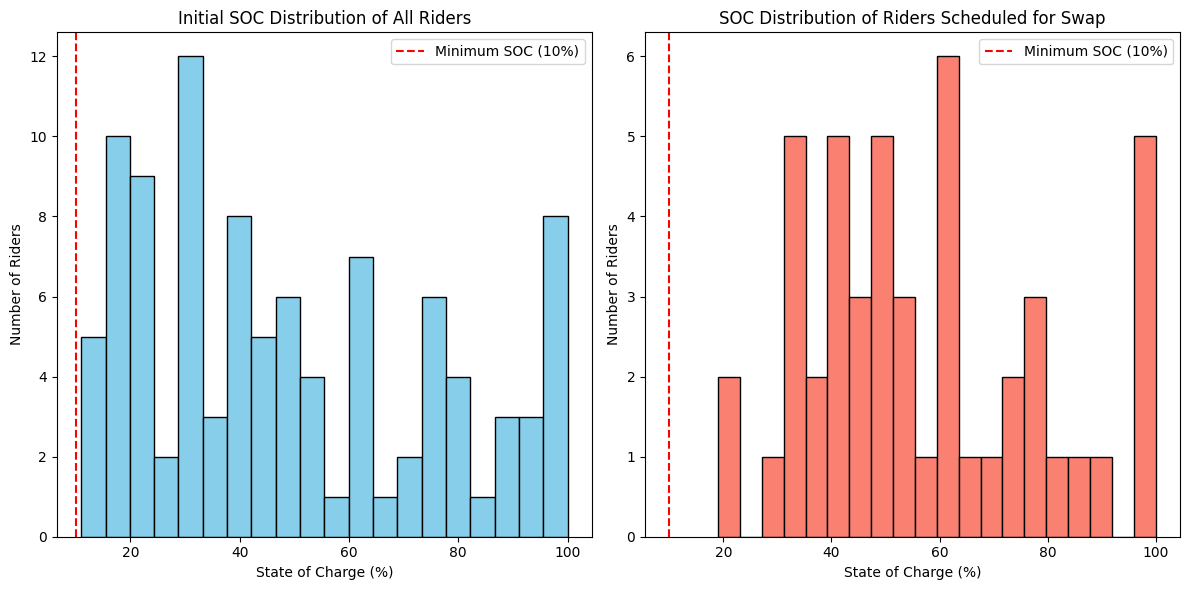

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_soc_distribution():
    # Load data
    with open('input_data.json') as f:
        input_data = json.load(f)
    with open('swap_plan.json') as f:
        swap_plan = json.load(f)
    
    # Get SOC values
    all_soc = [r['soc_pct'] for r in input_data['riders']]
    swapped_soc = [next(r['soc_pct'] for r in input_data['riders'] 
                       if r['rider_id'] == s['rider_id']) 
                  for s in swap_plan]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot SOC distribution
    plt.subplot(1, 2, 1)
    plt.hist(all_soc, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(10, color='red', linestyle='--', label='Minimum SOC (10%)')
    plt.title('Initial SOC Distribution of All Riders')
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Number of Riders')
    plt.legend()
    
    # Plot SOC of riders needing swaps
    plt.subplot(1, 2, 2)
    plt.hist(swapped_soc, bins=20, color='salmon', edgecolor='black')
    plt.axvline(10, color='red', linestyle='--', label='Minimum SOC (10%)')
    plt.title('SOC Distribution of Riders Scheduled for Swap')
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Number of Riders')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('soc_distribution.png')
    plt.show()

# Generate SOC plots
plot_soc_distribution()

## 4. Station Load Visualization (using Seaborn)


In [6]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Manish Alhat\AppData\Local\Temp\ipykernel_12796\71372967.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




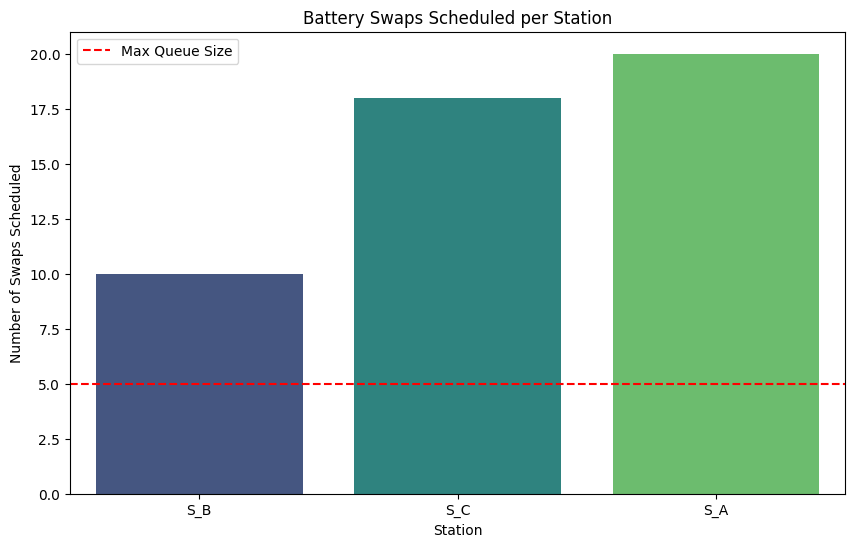

In [7]:
import seaborn as sns

def plot_station_load():
    # Load data
    with open('swap_plan.json') as f:
        swap_plan = json.load(f)
    
    # Count swaps per station
    station_counts = {}
    for swap in swap_plan:
        station_counts[swap['station_id']] = station_counts.get(swap['station_id'], 0) + 1
    
    # Convert to DataFrame for seaborn
    df = pd.DataFrame({
        'Station': list(station_counts.keys()),
        'Swaps Scheduled': list(station_counts.values())
    })
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Station', y='Swaps Scheduled', palette='viridis')
    
    # Add horizontal line for max queue
    plt.axhline(5, color='red', linestyle='--', label='Max Queue Size')
    
    plt.title('Battery Swaps Scheduled per Station')
    plt.ylabel('Number of Swaps Scheduled')
    plt.legend()
    plt.savefig('station_load.png')
    plt.show()

# Generate station load plot
plot_station_load()

## 5. Time-Lapse Animation (using Folium and IPython)


In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle, Rectangle
import matplotlib.colors as mcolors
from matplotlib.collections import PatchCollection
from datetime import datetime

# Load data
with open('input_data.json') as f:
    input_data = json.load(f)
with open('swap_plan.json') as f:
    swap_plan = json.load(f)

# Set up figure
fig, ax = plt.subplots(figsize=(12, 8), facecolor='#f0f0f0')
fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
ax.set_facecolor('#f0f0f0')

# Extract and normalize coordinates
def get_normalized_coords(data, ref_point):
    lngs = [x['lng'] - ref_point[0] for x in data]
    lats = [x['lat'] - ref_point[1] for x in data]
    return np.array(lngs), np.array(lats)

# Use first station as reference point
ref_point = (input_data['stations'][0]['lng'], input_data['stations'][0]['lat'])
rider_lngs, rider_lats = get_normalized_coords(input_data['riders'], ref_point)
station_lngs, station_lats = get_normalized_coords(input_data['stations'], ref_point)

# Set plot limits with padding
padding = 0.1
all_lngs = np.concatenate([rider_lngs, station_lngs])
all_lats = np.concatenate([rider_lats, station_lats])
ax.set_xlim(min(all_lngs)-padding, max(all_lngs)+padding)
ax.set_ylim(min(all_lats)-padding, max(all_lats)+padding)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
ax.set_title('Battery Swap Optimization\nTime: 00:00', fontsize=14, pad=20)

# Create colormap for SOC
soc_cmap = mcolors.LinearSegmentedColormap.from_list('soc', ['#ff0000', '#ffff00', '#00ff00'])

# Plot stations
station_markers = []
station_texts = []
station_queues = []

for i, station in enumerate(input_data['stations']):
    # Station base
    station_rect = Rectangle((station_lngs[i]-0.01, station_lats[i]-0.01), 
                            0.02, 0.02, 
                            color='#1f77b4', alpha=0.8, zorder=3)
    ax.add_patch(station_rect)
    
    # Station label
    station_text = ax.text(station_lngs[i], station_lats[i]+0.015, 
                          station['station_id'], 
                          ha='center', va='center', 
                          fontsize=10, weight='bold', zorder=4)
    
    # Queue indicator
    queue_text = ax.text(station_lngs[i], station_lats[i]-0.015, 
                        f"Queue: {station['queue_len']}", 
                        ha='center', va='center', 
                        fontsize=9, color='#333333', zorder=4)
    
    station_markers.append(station_rect)
    station_texts.append(station_text)
    station_queues.append(queue_text)

# Plot riders
rider_dots = ax.scatter(rider_lngs, rider_lats, 
                       c=[r['soc_pct'] for r in input_data['riders']], 
                       s=80, cmap=soc_cmap, 
                       vmin=0, vmax=100, alpha=0.8, 
                       edgecolors='#333333', linewidths=0.5, zorder=5)

# Rider labels (initially hidden)
rider_labels = []
for i, rider in enumerate(input_data['riders']):
    label = ax.text(rider_lngs[i], rider_lats[i], 
                   rider['rider_id'], 
                   ha='center', va='center', 
                   fontsize=7, alpha=0, zorder=6)
    rider_labels.append(label)

# Plot paths (initially hidden)
paths = []
for swap in swap_plan:
    rider_idx = next(i for i, r in enumerate(input_data['riders']) 
                    if r['rider_id'] == swap['rider_id'])
    station_idx = next(i for i, s in enumerate(input_data['stations']) 
                     if s['station_id'] == swap['station_id'])
    
    path, = ax.plot([], [], 'k-', alpha=0.3, lw=1, zorder=2)
    paths.append((path, rider_idx, station_idx, swap))

# Add colorbar
cbar = plt.colorbar(rider_dots, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label('State of Charge (%)', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='Station',
              markerfacecolor='#1f77b4', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Rider',
              markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], color='k', lw=1, label='Swap Path', alpha=0.3)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

# Animation functions
def init():
    """Initialize animation"""
    # Reset all elements
    rider_dots.set_offsets(np.column_stack([rider_lngs, rider_lats]))
    rider_dots.set_array(np.array([r['soc_pct'] for r in input_data['riders']]))
    
    for label in rider_labels:
        label.set_alpha(0)
    
    for path, _, _, _ in paths:
        path.set_data([], [])
    
    return [rider_dots] + rider_labels + [p[0] for p in paths]

def update(frame):
    """Update animation for each frame"""
    current_time = frame * 5  # 5 minutes per frame
    
    # Update title with current time
    ax.set_title(f'Battery Swap Optimization\nTime: {current_time:02d}:00', fontsize=14, pad=20)
    
    # Update rider positions and SOC
    new_positions = np.column_stack([rider_lngs.copy(), rider_lats.copy()])
    soc_values = [r['soc_pct'] for r in input_data['riders']]
    
    for path, rider_idx, station_idx, swap in paths:
        if swap['depart_ts'] <= current_time <= swap['arrive_ts']:
            # Calculate position along path
            progress = (current_time - swap['depart_ts']) / (swap['arrive_ts'] - swap['depart_ts'])
            new_lng = rider_lngs[rider_idx] + (station_lngs[station_idx] - rider_lngs[rider_idx]) * progress
            new_lat = rider_lats[rider_idx] + (station_lats[station_idx] - rider_lats[rider_idx]) * progress
            
            # Update rider position
            new_positions[rider_idx] = [new_lng, new_lat]
            
            # Update path visibility
            path.set_data([rider_lngs[rider_idx], station_lngs[station_idx]],
                         [rider_lats[rider_idx], station_lats[station_idx]])
            
            # Update SOC during travel (linear decrease)
            if current_time < swap['arrive_ts']:
                distance = np.sqrt((station_lngs[station_idx] - rider_lngs[rider_idx])**2 + 
                           (station_lats[station_idx] - rider_lats[rider_idx])**2)
                soc_values[rider_idx] = max(10, input_data['riders'][rider_idx]['soc_pct'] - 
                                       (progress * distance * 4))
        
        elif current_time > swap['arrive_ts']:
            # Rider is at station (fully charged)
            new_positions[rider_idx] = [station_lngs[station_idx], station_lats[station_idx]]
            soc_values[rider_idx] = 100
    
    # Update rider positions and SOC
    rider_dots.set_offsets(new_positions)
    rider_dots.set_array(np.array(soc_values))
    
    # Update rider labels (show on hover effect)
    for i, label in enumerate(rider_labels):
        if (new_positions[i][0] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0]) > 0.7:
            label.set_position((new_positions[i][0]-0.02, new_positions[i][1]))
        else:
            label.set_position((new_positions[i][0]+0.02, new_positions[i][1]))
        label.set_alpha(0.8 if frame % 10 < 5 else 0)  # Blinking effect
    
    # Update station queues
    for i, station in enumerate(input_data['stations']):
        queue = 0
        for swap in swap_plan:
            if swap['station_id'] == station['station_id']:
                if swap['swap_start_ts'] <= current_time <= swap['swap_end_ts']:
                    queue += 1
        
        # Update queue text
        station_queues[i].set_text(f"Queue: {queue}")
        
        # Change station color based on queue length
        if queue >= 5:
            station_markers[i].set_facecolor('#ff0000')
        elif queue >= 3:
            station_markers[i].set_facecolor('#ffa500')
        else:
            station_markers[i].set_facecolor('#1f77b4')
    
    return [rider_dots] + rider_labels + [p[0] for p in paths] + station_queues + station_markers

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, 61, 1),  # 60 minutes in 1-min steps
                    init_func=init, blit=False, interval=200)

# Save as GIF
print("Creating animation...")
ani.save('battery_swap_animation.gif', writer='pillow', dpi=100, fps=10)
print("Animation saved as 'battery_swap_animation.gif'")

plt.close()

Creating animation...
Animation saved as 'battery_swap_animation.gif'
